## Intro

When Librosa loads an audio file, there is a default sample rate, which is the number of samples from the mp3's audio signal for one second. Therefore,
to get the length of a song in real time we take the length of the read-in array and divide by the sample rate for that audio sample.

In [1]:
# system packages
import os
import warnings

# usual imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Sequential

## audio tools
import librosa
from torchaudio import info

# my functions and classes
from utilities import (
    view_melspec,
    read_metadata_file,
    Batch_generator,
    id_from_path,
    attach_onehot_encoding,
    mp3_to_mel_path
)

# for timing loops
import tqdm

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# VERY GLOBAL VARIABLES
audio_dir = "./data/fma_small/"
global_dur = 0.5
global_sr = 8000

The next code chunk is Super handy function that just searches for every mp3 file within the audio directory. 
My audio folder has a bunch of subfolders like '000', '099', etc, and the audio files are
one level further down.

In [3]:
filepaths = librosa.util.files.find_files(audio_dir)

Here is what a typical load looks like. Specifying `sr=None` ensures that the file's default sample-rate is preserved. 
We can also specify the duration with `librosa.load`.

In [4]:
example_source, sr = librosa.load(filepaths[1], sr=None, duration=2)
librosa.get_duration(example_source, sr=sr)

2.0

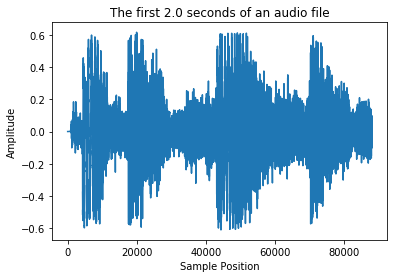

In [5]:
plt.plot(example_source)
plt.title(
    f"The first {librosa.get_duration(example_source, sr=sr)} seconds of an audio file"
)
plt.xlabel("Sample Position")
plt.ylabel("Amplitude")
plt.show()

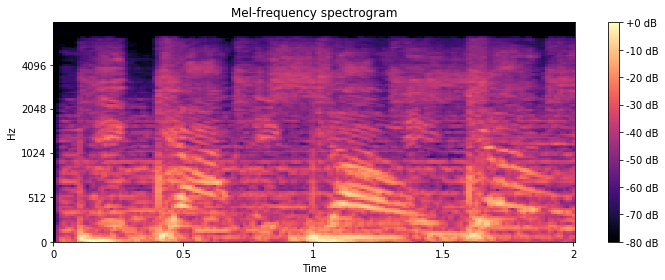

In [6]:
view_melspec(example_source, sr)

## How long does a typical load take?

On my linux virtual machine, one second of audio takes between 143 and 214 milliseconds to load one second of audio (down to 129 ms if we don't force a sample rate). 
Multiplying this number by 8 is about how long it will take to load the entire dataset in. I estimate about 15 minutes for the whole FMA Small dataset.

However, on my macbook it takes about 16 ms to load one second of audio in. For five seconds of audio, about 34 ms. This is much faster than the ubuntu machine! This means an estimated 134 seconds, or about two minutes.

This runs a lot faster at 270 microseconds on my ubuntu virtual machine, so it will be a better tool to 
check for integrity. On the macbook it takes about 330 microseconds, a bit slower.


## Check for integrity

This is the only point where I will use `torchaudio` for the `torchaudio.info` method. This method
tries to open the file without loading it into memory. This allows us to check
for corrupted mp3 files. If this leads to a very long list of files, double check the integrity
of your download.

In [7]:
bad_files = []
too_short_duration = 5.0  # seconds
for file in filepaths:
    try:
        info_obj = info(file)[0]

        # Add a file to the bad list if it is shorter than 5 seconds.
        if info_obj.length / (info_obj.rate * info_obj.channels) < 5.0:
            bad_files.append(file)

    except RuntimeError:
        bad_files.append(file)
bad_files

['/Users/awray_mac/Documents/data_sci.nosync/fma/data/fma_small/098/098567.mp3',
 '/Users/awray_mac/Documents/data_sci.nosync/fma/data/fma_small/099/099134.mp3',
 '/Users/awray_mac/Documents/data_sci.nosync/fma/data/fma_small/108/108925.mp3',
 '/Users/awray_mac/Documents/data_sci.nosync/fma/data/fma_small/133/133297.mp3']

## Estimating memory cost

This takes about 1.4 GB of memory to store all song audio.

## Managing Metadata 

The following code takes the giant metadata file coming with the FMA datasets and selects
the track ids and the genres.

In [8]:
metadata_path = os.path.join("data", "fma_metadata", "tracks.csv")

# Read in the metadata and process it. See utilities.py for explanation.
meta_df = read_metadata_file(metadata_path, filepaths, bad_files)

# shuffle the dataset
meta_df = meta_df.sample(frac=1, random_state=1)

# get a list of the genres
genre_list = list(meta_df.genre.unique())

Dropped 4 rows from the dataframe.


In [9]:
## check to make sure each path points to the right file
meta_df["track_id"].equals(meta_df["mp3_path"].apply(lambda x: int(id_from_path(x))))

True

In [10]:
meta_df.head()

,track_id,genre,mp3_path
7982,152568,Instrumental,/Users/awray_mac/Documents/data_sci.nosync/fma...
5566,116525,Experimental,/Users/awray_mac/Documents/data_sci.nosync/fma...
2879,65756,Pop,/Users/awray_mac/Documents/data_sci.nosync/fma...
5250,113273,International,/Users/awray_mac/Documents/data_sci.nosync/fma...
2202,53724,International,/Users/awray_mac/Documents/data_sci.nosync/fma...


## Preprocessing

In [11]:
melspec_dir = os.path.join(".", "data", "fma_small_melspecs")

The next cell will process `.mp3` files into melspectrograms, which are numpy arrays. Numpy arrays are saved as `.npz` files. The next cell will (most likely) be set to a raw cell, so that it does not run when executing the entire notebook.

(Turning a cell from code to raw is like an on-off switch for a cell!)

In [12]:
# If the preprocessing step was not run, this will append the correct paths.
if "mel_path" not in meta_df.columns:
    meta_df["mel_path"] = meta_df["mp3_path"].apply(
        lambda x: mp3_to_mel_path(x, melspec_dir)
    )

In [13]:
# encode genre column
meta_df = attach_onehot_encoding(meta_df, "genre")

## Loading Data

The class `Batch_generator` loads in batches one at a time so as to not load a huge amount of data into the kernel.

Now that the preprocessing step is done, I can either continue using the custom generator class approach, or I could try to set up preprocessing to use `flow_from_directory`. 

In [15]:
batch_size = 8


training_generator = Batch_generator(meta_df.iloc[:4800, :], batch_size=batch_size)
validation_generator = Batch_generator(meta_df.iloc[4800:6400, :], batch_size=batch_size)
test_generator = Batch_generator(meta_df.iloc[6400:, :], batch_size=batch_size)

## Logistic Regression

It's worth it to see if we can train a logistic regression model and see how well it does at classifying the genres. 

In [20]:
input_shape = training_generator[0][0].shape[1:]

In [27]:
logistic_reg = Sequential([
    Flatten(data_format=None, input_shape = input_shape),
    Dense(8, activation="softmax"),
])


logistic_reg.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

logistic_reg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 8200      
Total params: 8,200
Trainable params: 8,200
Non-trainable params: 0
_________________________________________________________________


In [28]:
num_epochs = 10

logistic_reg.fit_generator(generator = training_generator,
                           epochs=num_epochs,
                           verbose=1,
                           validation_data = validation_generator
                          )

#                            validation_data = validation_generator,
#                            validation_steps = len(validation_generator)

Epoch 1/10
600/600 [==============================] - 19s 32ms/step - loss: 11.7780 - accuracy: 0.1783 - val_loss: 13.6614 - val_accuracy: 0.0731
Epoch 2/10
600/600 [==============================] - 19s 32ms/step - loss: 11.3513 - accuracy: 0.2229 - val_loss: 13.6849 - val_accuracy: 0.0869
Epoch 3/10
600/600 [==============================] - 19s 32ms/step - loss: 11.1276 - accuracy: 0.2346 - val_loss: 13.6104 - val_accuracy: 0.0962
Epoch 4/10
600/600 [==============================] - 20s 33ms/step - loss: 10.9373 - accuracy: 0.2502 - val_loss: 13.6315 - val_accuracy: 0.0950
Epoch 5/10
600/600 [==============================] - 18s 31ms/step - loss: 10.7602 - accuracy: 0.2637 - val_loss: 13.8996 - val_accuracy: 0.0787
Epoch 6/10
600/600 [==============================] - 20s 33ms/step - loss: 10.6914 - accuracy: 0.2715 - val_loss: 13.9129 - val_accuracy: 0.0794
Epoch 7/10
600/600 [==============================] - 19s 32ms/step - loss: 10.4387 - accuracy: 0.2900 - val_loss: 13.9842 -

Save model next!

## CNN

First we explore how well a traditional convolutional neural net works on this dataset.